## Importing the Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # supress warnings

## Reading the Dataset

In [2]:
data = pd.read_csv('Global+SuperStore+Data.csv')

In [3]:
data.shape # 51290 transactions and 6 features

(51290, 5)

In [4]:
data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


Since we need to do a monthly forecast, we first need to convert the transaction level data to monthly times series data. 

### Getting the data in the required Month-Year format

In [6]:
data['Order Date'] = pd.to_datetime(data['Order Date']).dt.to_period('m')

In [7]:
data.head()

,Order Date,Segment,Market,Sales,Profit
0,2012-07,Consumer,US,2309.650,762.1845
1,2013-05,Corporate,APAC,3709.395,-288.7650
2,2013-10,Consumer,APAC,5175.171,919.9710
3,2013-01,Home Office,EU,2892.510,-96.5400
4,2013-05,Consumer,Africa,2832.960,311.5200


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Order Date  51290 non-null  period[M]
 1   Segment     51290 non-null  object   
 2   Market      51290 non-null  object   
 3   Sales       51290 non-null  float64  
 4   Profit      51290 non-null  float64  
dtypes: float64(2), object(2), period[M](1)
memory usage: 2.0+ MB


In [9]:
data["Market"].unique() # Segments according to geography

array(['US', 'APAC', 'EU', 'Africa', 'EMEA', 'LATAM', 'Canada'],
      dtype=object)

In [10]:
data["Segment"].unique() # Segments according to customer

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [11]:
data["Concate"] = data["Market"] + data["Segment"]
data.head()

,Order Date,Segment,Market,Sales,Profit,Concate
0,2012-07,Consumer,US,2309.650,762.1845,USConsumer
1,2013-05,Corporate,APAC,3709.395,-288.7650,APACCorporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APACConsumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EUHome Office
4,2013-05,Consumer,Africa,2832.960,311.5200,AfricaConsumer


In [12]:
data['Concate'].unique()

array(['USConsumer', 'APACCorporate', 'APACConsumer', 'EUHome Office',
       'AfricaConsumer', 'USCorporate', 'EMEAConsumer',
       'LATAMHome Office', 'EUCorporate', 'EMEACorporate',
       'LATAMConsumer', 'EUConsumer', 'USHome Office', 'LATAMCorporate',
       'AfricaCorporate', 'APACHome Office', 'EMEAHome Office',
       'AfricaHome Office', 'CanadaCorporate', 'CanadaHome Office',
       'CanadaConsumer'], dtype=object)

### Defining a new dataset to get aggregated monthly data for profit to identify which segment to forecast for

In [13]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Concate
0,2012-07,Consumer,US,2309.650,762.1845,USConsumer
1,2013-05,Corporate,APAC,3709.395,-288.7650,APACCorporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APACConsumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EUHome Office
4,2013-05,Consumer,Africa,2832.960,311.5200,AfricaConsumer


In [14]:
datag = data.pivot_table(index='Order Date', values='Profit', columns='Concate', aggfunc='sum')

In [15]:
datag.head() 

Concate,APACConsumer,APACCorporate,APACHome Office,AfricaConsumer,AfricaCorporate,AfricaHome Office,CanadaConsumer,CanadaCorporate,CanadaHome Office,EMEAConsumer,...,EMEAHome Office,EUConsumer,EUCorporate,EUHome Office,LATAMConsumer,LATAMCorporate,LATAMHome Office,USConsumer,USCorporate,USHome Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [16]:
datag.shape # 48 months i.e. 4 years

(48, 21)

In [17]:
#splitting the dataset into train and test for calculation for cov
train_len = 42
train_datag = datag[0:train_len] # 42 months data used for training
test_datag = datag[train_len:] # 6 months data for validation
# No sampling done here - for time series data, maintaining the sequence is important

In [18]:
train_datag.mean()

Concate
APACConsumer         4400.894243
APACCorporate        2574.919807
APACHome Office      1511.088314
AfricaConsumer        957.707000
AfricaCorporate       412.617571
AfricaHome Office     377.221071
CanadaConsumer        225.987632
CanadaCorporate        90.980294
CanadaHome Office     118.003750
EMEAConsumer          423.960286
EMEACorporate         182.642643
EMEAHome Office        84.231366
EUConsumer           3699.977143
EUCorporate          2216.299429
EUHome Office        1224.456536
LATAMConsumer        2295.555697
LATAMCorporate       1122.633016
LATAMHome Office      818.398941
USConsumer           2686.740912
USCorporate          1754.199083
USHome Office        1132.065762
dtype: float64

In [19]:
np.std(train_datag)

Concate
APACConsumer         2300.457687
APACCorporate        1364.837734
APACHome Office      1523.508658
AfricaConsumer       1254.932072
AfricaCorporate       780.566850
AfricaHome Office     759.322203
CanadaConsumer        282.555788
CanadaCorporate       162.493114
CanadaHome Office     279.632866
EMEAConsumer         1124.552711
EMEACorporate        1160.698430
EMEAHome Office       651.283095
EUConsumer           2202.282289
EUCorporate          1600.336696
EUHome Office        1148.627937
LATAMConsumer        1569.632686
LATAMCorporate        990.360880
LATAMHome Office      957.275713
USConsumer           2715.031412
USCorporate          1880.200775
USHome Office        1272.476439
dtype: float64

In [20]:
np.std(train_datag)/train_datag.mean()

Concate
APACConsumer         0.522725
APACCorporate        0.530051
APACHome Office      1.008219
AfricaConsumer       1.310351
AfricaCorporate      1.891744
AfricaHome Office    2.012937
CanadaConsumer       1.250315
CanadaCorporate      1.786025
CanadaHome Office    2.369695
EMEAConsumer         2.652495
EMEACorporate        6.355024
EMEAHome Office      7.732073
EUConsumer           0.595215
EUCorporate          0.722076
EUHome Office        0.938072
LATAMConsumer        0.683770
LATAMCorporate       0.882177
LATAMHome Office     1.169693
USConsumer           1.010530
USCorporate          1.071829
USHome Office        1.124030
dtype: float64

In [21]:
covs = pd.DataFrame(columns = ['Segment', 'CoV']) # Initializing a dataframe with two columns

In [22]:
# writing a loop for cov values for all market segments
for i in datag.columns:
    #print(i)
    temp = {"Segment": i, "CoV": np.std(train_datag[i])/np.mean(train_datag[i])}
    covs = covs.append(temp, ignore_index=True)

In [23]:
covs.head()# here COV is calculated as lower is the COV value for a market , more profitable it is 

,Segment,CoV
0,APACConsumer,0.522725
1,APACCorporate,0.530051
2,APACHome Office,1.008219
3,AfricaConsumer,1.310351
4,AfricaCorporate,1.891744


In [24]:
#listing cov values in the order of their market segments
covs.sort_values(by='CoV')

,Segment,CoV
0,APACConsumer,0.522725
1,APACCorporate,0.530051
12,EUConsumer,0.595215
15,LATAMConsumer,0.683770
13,EUCorporate,0.722076
16,LATAMCorporate,0.882177
14,EUHome Office,0.938072
2,APACHome Office,1.008219
18,USConsumer,1.010530
19,USCorporate,1.071829


We prefer the segment with the lowest CoV value since this segment gives the relatively stable profit over the past months which will lead to reliable forecasts.

We will extract data only for APACConsumer and forecast the sales and quatity only for this segment.

## Subsetting only the rows for APACConsumer

From here we will consider only the APACConsumer segment to forecast the 6 month sales and quantity.

In [25]:
data1 = data.loc[data.Concate == 'APACConsumer'] # Subsetting the original data
data1.head()

,Order Date,Segment,Market,Sales,Profit,Concate
2,2013-10,Consumer,APAC,5175.171,919.971,APACConsumer
6,2011-07,Consumer,APAC,1822.080,564.840,APACConsumer
7,2012-04,Consumer,APAC,5244.840,996.480,APACConsumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APACConsumer
29,2012-02,Consumer,APAC,1878.720,582.360,APACConsumer


In [26]:
data1.shape 

(5699, 6)

In [27]:
data1.head()

,Order Date,Segment,Market,Sales,Profit,Concate
2,2013-10,Consumer,APAC,5175.171,919.971,APACConsumer
6,2011-07,Consumer,APAC,1822.080,564.840,APACConsumer
7,2012-04,Consumer,APAC,5244.840,996.480,APACConsumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APACConsumer
29,2012-02,Consumer,APAC,1878.720,582.360,APACConsumer


In [28]:
#grouping all the order dates and arranging them since it is transaction level data and we need monthly aggregated data
data1 = data1.groupby(['Order Date']).sum()

In [29]:
data1.shape

(48, 2)

In [30]:
data1

,Sales,Profit
Order Date,,
2011-01,18821.9898,2254.4898
2011-02,23313.3531,4627.8531
2011-03,26518.4919,2337.8319
2011-04,12046.0923,633.6423
2011-05,25941.9000,3838.9500
2011-06,30398.9316,5231.0316
2011-07,22431.5949,1928.5449
2011-08,20331.0735,1101.5235
2011-09,24860.3949,3088.9449


## APAC Consumer

Now, since we are considering only univariate time series, let's proceed with forecasting only the sales.

In [31]:
print(data1.head())
print(data1.shape)

                 Sales     Profit
Order Date                       
2011-01     18821.9898  2254.4898
2011-02     23313.3531  4627.8531
2011-03     26518.4919  2337.8319
2011-04     12046.0923   633.6423
2011-05     25941.9000  3838.9500
(48, 2)


In [32]:
#dropping all the columns and keeping only sales
data1 = data1[['Sales']]
print(data1.head())

                 Sales
Order Date            
2011-01     18821.9898
2011-02     23313.3531
2011-03     26518.4919
2011-04     12046.0923
2011-05     25941.9000


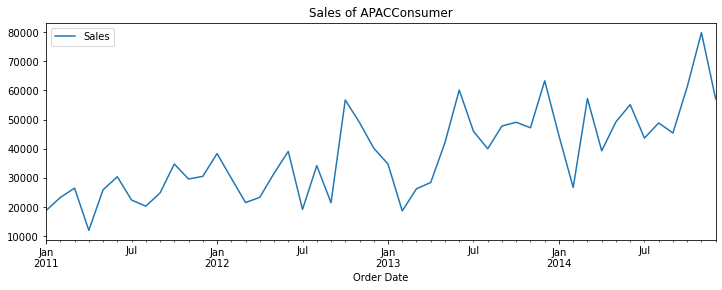

In [33]:
#plotting the sales of APAC Consumer
data1.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales of APACConsumer')
plt.show()

Here we observe a linear trend; the seasonality is not as obvious as the airlines dataset you have studied. Lets decompose this time series to get a better idea.

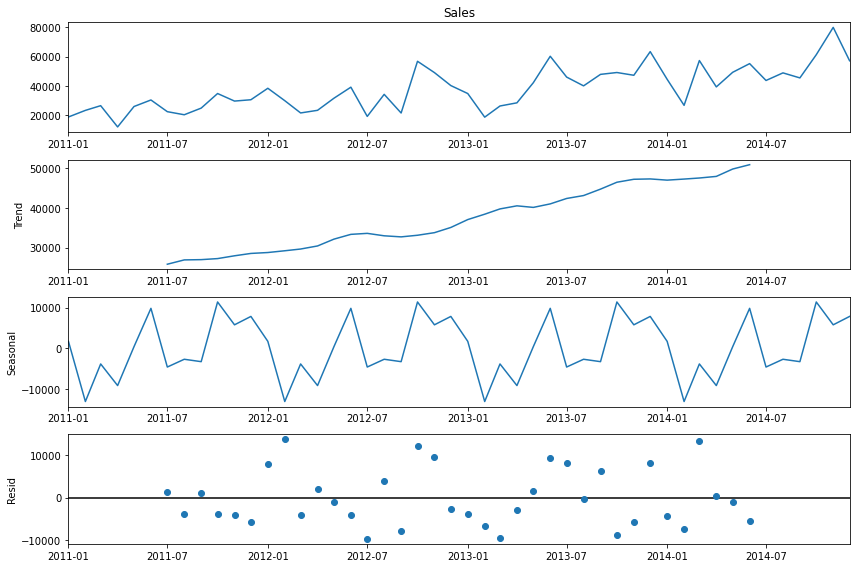

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
from statsmodels.tsa.seasonal import seasonal_decompose
data1.Sales.interpolate(inplace = True)
data1.Sales.index=data1.Sales.index.to_timestamp()
decomposition = seasonal_decompose(data1.Sales)
fig = decomposition.plot()
plt.show()

In [35]:
#converting datetime to timestamp
data1 = data1.to_timestamp() # converting datetime to timestamp; 
                             # sometimes get error when running the models later if this step is not included

In [36]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2011-01-01 to 2014-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


# Forecasting using different algorithms

## Train-Test-Split

In [37]:
train_len = 42
train = data1[0:train_len]
test = data1[train_len:]

## Naive Method

In [38]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1] # The last value of sales from the train data will be forecasted for test data

### Plot train, test and forecast

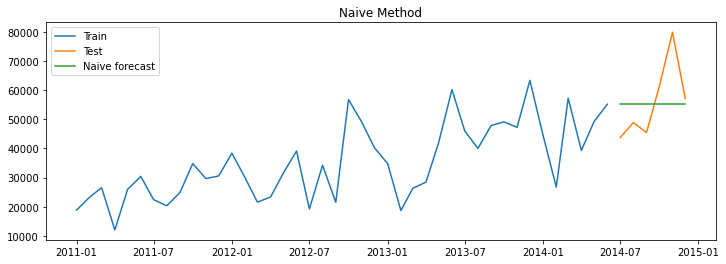

In [39]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

#### As we know that Naive Method forecasts the value on the basis of last value of the training data set , this is quiet clear from the above forecast

### Calculate MAPE (Mean absolute percentage error)

In [40]:
from sklearn.metrics import mean_squared_error
rmse1 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_naive['naive_forecast'])),2)
mape1 = round(np.mean(np.abs(test['Sales'] - y_hat_naive['naive_forecast'])/test['Sales'])*100,2)
# take the absolute difference between the actual value and its forecast and divide by the actual value multiplied by 100 
# to get the percentage which is then rounded to two decimal places.
results1 = pd.DataFrame({'Method': ['Naive_Method'],'RMSE':[rmse1],'MAPE':[mape1]})
results1

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47


### Average Forecast

In [41]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()

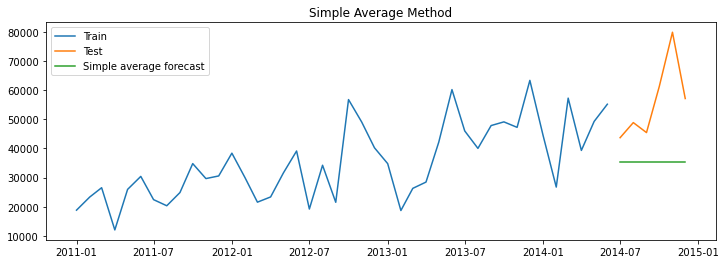

In [42]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

#### The average forecast takes all the values of the training data set and then predicts the projected values by averaging 

In [43]:
from sklearn.metrics import mean_squared_error
rmse2 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_avg['avg_forecast'])),2)
mape2 = round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

In [44]:
results2 = pd.DataFrame({'Method':['Average_Method'],'RMSE':[rmse2],'MAPE':[mape2]})
results2

,Method,RMSE,MAPE
0,Average_Method,24146.06,34.34


In [45]:
results_1 = pd.concat([results1,results2])
results_1

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34


### Simple Moving Average method

In [46]:
y_hat_sma = data1.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data1['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

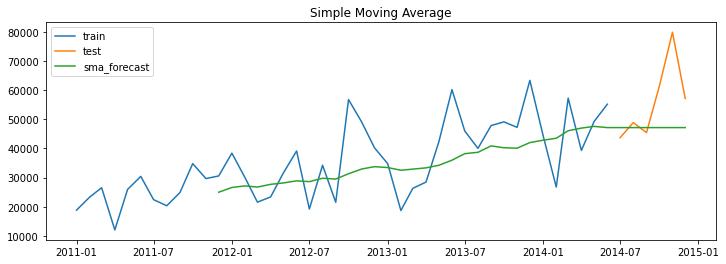

In [47]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'train')
plt.plot(test['Sales'],label = 'test')
plt.plot(y_hat_sma['sma_forecast'], label = 'sma_forecast')
plt.legend(loc = 'best')
plt.title('Simple Moving Average')
plt.show(block = False)

#### The above forecast is of the moving average 

In [48]:
rmse3 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_sma['sma_forecast'][train_len:])),2)
mape3 = round(np.mean(np.abs(test['Sales'] - y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)
print(rmse3,mape3)

15192.01 16.1


In [49]:
results3 = pd.DataFrame({'Method': ['Simple Moving Average'],'RMSE':[rmse3],'MAPE':[mape3]})
results3

,Method,RMSE,MAPE
0,Simple Moving Average,15192.01,16.1


In [50]:
results_2 = pd.concat([results1,results2,results3])
results_2

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10


### Simple Exponential Smoothing

In [51]:
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()##here we can observe that we are copying test and not the whole data
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

In [52]:
train['Sales']

Order Date
2011-01-01    18821.9898
2011-02-01    23313.3531
2011-03-01    26518.4919
2011-04-01    12046.0923
2011-05-01    25941.9000
2011-06-01    30398.9316
2011-07-01    22431.5949
2011-08-01    20331.0735
2011-09-01    24860.3949
2011-10-01    34787.2881
2011-11-01    29648.3547
2011-12-01    30554.8614
2012-01-01    38369.3127
2012-02-01    29921.4267
2012-03-01    21561.5634
2012-04-01    23356.0467
2012-05-01    31586.4477
2012-06-01    39108.9078
2012-07-01    19210.6728
2012-08-01    34225.1154
2012-09-01    21521.7960
2012-10-01    56741.1831
2012-11-01    49030.2528
2012-12-01    40201.6080
2013-01-01    34777.2885
2013-02-01    18697.8216
2013-03-01    26298.6804
2013-04-01    28451.7387
2013-05-01    42147.0264
2013-06-01    60163.8225
2013-07-01    45990.8958
2013-08-01    40007.0493
2013-09-01    47835.0258
2013-10-01    49095.7305
2013-11-01    47218.6824
2013-12-01    63324.6315
2014-01-01    44475.2703
2014-02-01    26737.0524
2014-03-01    57235.1793
2014-04-01    

In [53]:
y_hat_ses['ses_forecast']

Order Date
2014-07-01    47448.096529
2014-08-01    47448.096529
2014-09-01    47448.096529
2014-10-01    47448.096529
2014-11-01    47448.096529
2014-12-01    47448.096529
Freq: MS, Name: ses_forecast, dtype: float64

In [54]:
model_fit.forecast(len(test)).reset_index()[0]

0    47448.096529
1    47448.096529
2    47448.096529
3    47448.096529
4    47448.096529
5    47448.096529
Name: 0, dtype: float64

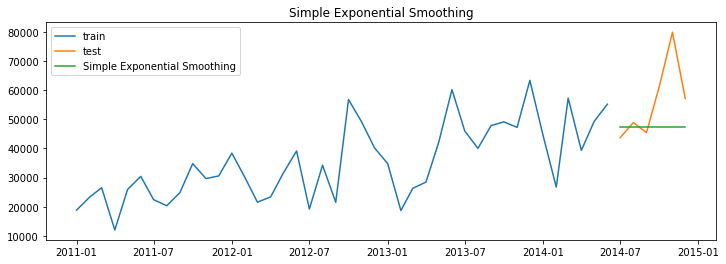

In [55]:
plt.figure(figsize =(12,4))
plt.plot(train['Sales'],label = 'train')
plt.plot(test['Sales'],label = 'test')
plt.plot(y_hat_ses['ses_forecast'],label = 'Simple Exponential Smoothing')
plt.title('Simple Exponential Smoothing')
plt.legend(loc = 'best')
plt.show(block = False)

### here we do the smoothing process by taking a smoothing level of 0.2 ,also in this method only level is taken

In [56]:
rmse4 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_ses['ses_forecast'])),2)
mape4 = round(np.mean(np.abs((test['Sales']- y_hat_ses['ses_forecast'])/test['Sales']))*100,2)

In [57]:
results4 = pd.DataFrame({'Method': ['Simple Exponetial Smooothing'],'RMSE':[rmse4],'MAPE':[mape4]})
results_3 = pd.concat([results1,results2,results3,results4])
results_3

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99


### Exponential Smoothing

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
model = ExponentialSmoothing(train['Sales'],seasonal_periods = 12,trend = 'additive',seasonal = None)
model_fit = model.fit(smoothing_level = 0.2,smoothing_slope = 0.01, optimized = False)
model_fit.params
y_hat_holt = test.copy()
y_hat_holt['hes_forecast'] = model_fit.forecast(len(test))

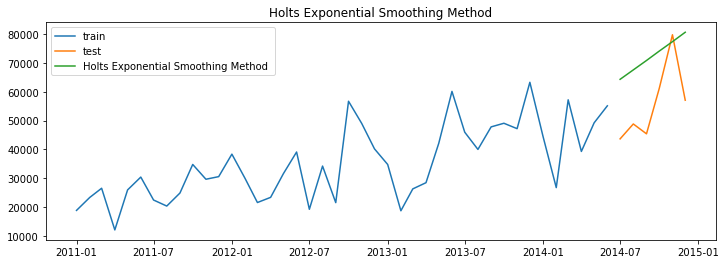

In [59]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'],label ='train')
plt.plot(test['Sales'],label ='test')
plt.plot(y_hat_holt['hes_forecast'],label ='Holts Exponential Smoothing Method ')
plt.legend(loc = 'best')
plt.title('Holts Exponential Smoothing Method')
plt.show(block = False)

### now we have included trend as well with the level , only seasonality is left now to be taken

In [60]:
rmse5 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_holt['hes_forecast'])),2)
mape5 = round(np.mean(np.abs((test['Sales']- y_hat_holt['hes_forecast'])/test['Sales']))*100,2)
results5 = pd.DataFrame({'Method': ['Exponetial Smooothing'],'RMSE':[rmse5],'MAPE':[mape5]})
results_4 = pd.concat([results1,results2,results3,results4,results5])
results_4

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57


### Holts Winter Exponential Smoothing Additive Method  with Level , Trend and Season . 

In [61]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
model = ExponentialSmoothing(train['Sales'],seasonal_periods = 12,trend = 'additive',seasonal = 'additive')
model_fit = model.fit( optimized = True)
model_fit.params
y_hwa_holt = test.copy()
y_hwa_holt['hwa_forecast'] = model_fit.forecast(24)

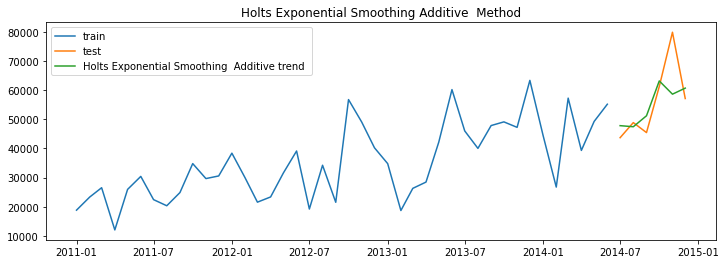

In [62]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'],label ='train')
plt.plot(test['Sales'],label ='test')
plt.plot(y_hwa_holt['hwa_forecast'],label ='Holts Exponential Smoothing  Additive trend ')
plt.legend(loc = 'best')
plt.title('Holts Exponential Smoothing Additive  Method')
plt.show(block = False)

#### now we have taken all three level, trend and seasonality, also we are following an additive method 

In [63]:
rmse7 = round(np.sqrt(mean_squared_error(test['Sales'],y_hwa_holt['hwa_forecast'])),2)
mape7 = round(np.mean(np.abs((test['Sales']- y_hwa_holt['hwa_forecast'])/test['Sales']))*100,2)
results6 = pd.DataFrame({'Method': ['Holts Exponential Smoothing  Additive trend'],'RMSE':[rmse7],'MAPE':[mape7]})
results_5 = pd.concat([results1,results2,results3,results4,results5,results6])
results_5

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17


### Hot Exponential Smoothing method multiplicative method

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
model = ExponentialSmoothing(train['Sales'],seasonal_periods = 12,trend = 'additive',seasonal = 'multiplicative')
model_fit = model.fit( optimized = True)
print(model_fit.params)
y_hwm_holt = test.copy()
y_hwm_holt['hwm_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 34110.965325000005, 'initial_trend': 730.4167145833339, 'initial_seasons': array([0.55178708, 0.68345627, 0.77741839, 0.35314428, 0.76051498,
       0.8911777 , 0.65760657, 0.5960275 , 0.72880948, 1.01982714,
       0.86917372, 0.89574895]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


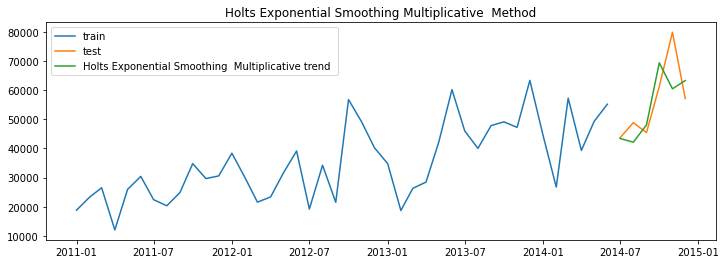

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'],label ='train')
plt.plot(test['Sales'],label ='test')
plt.plot(y_hwm_holt['hwm_forecast'],label ='Holts Exponential Smoothing  Multiplicative trend ')
plt.legend(loc = 'best')
plt.title('Holts Exponential Smoothing Multiplicative  Method')
plt.show(block = False)

#### now we have taken all three level, trend and seasonality, also we are following an multiplicative method 

In [66]:
rmse8 = round(np.sqrt(mean_squared_error(test['Sales'],y_hwm_holt['hwm_forecast'])),2)
mape8 = round(np.mean(np.abs((test['Sales']- y_hwm_holt['hwm_forecast'])/test['Sales']))*100,2)
results7 = pd.DataFrame({'Method': ['Holts Exponential Smoothing  Multiplicative trend'],'RMSE':[rmse8],'MAPE':[mape8]})
results_6 = pd.concat([results1,results2,results3,results4,results5,results6,results7])
results_6

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43


## Auto Regressive Models

#### Stationary vs Non Stationary Test Series

#### Time Series plot

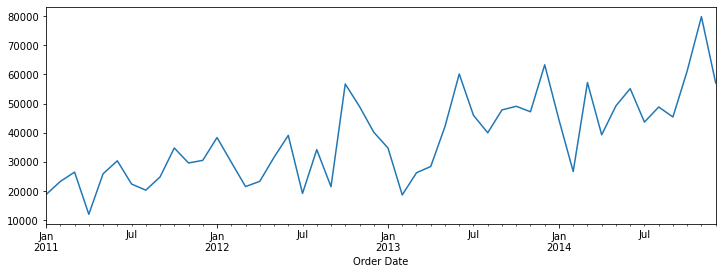

In [67]:
data1['Sales'].plot(figsize =(12,4))
plt.show(block = False)

In [68]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data1['Sales'])
print('ADF Statistic : %f '% adf_test[0])
print('Critical Value @ 0.05: %0.2f' %adf_test[4]['5%'])
print(f'p-value is :%0.3f'%adf_test[1])
print(f'p-value is {adf_test[1]}')
#The Null Hypothesis of the ADF test is that the time series is not stationary.
# So here the p -value is greater than 0.05 so it means we are accepting null hypothesis and the time series is
# non -stationary 

ADF Statistic : -3.376024 
Critical Value @ 0.05: -2.93
p-value is :0.012
p-value is 0.011803859657119813


In [69]:
from statsmodels.tsa.stattools import kpss 
kpss_test = kpss(data1['Sales'])
print(f'KPSS Statistic is : {kpss_test}')
print(f'The p- value is {kpss_test[1]}')
print(f'Crtical Value @ 0.05 is {kpss_test[3]}')
print('Crtical Value @ 0.05 is:%0.2f'% kpss_test[3]['5%'])
#The Null Hypothesis of the KPSS test is that the time series is stationary

KPSS Statistic is : (0.5770764651955997, 0.024720321345854567, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
The p- value is 0.024720321345854567
Crtical Value @ 0.05 is {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Crtical Value @ 0.05 is:0.46


In [70]:
#### As p value is l

## Box Cox Transformation

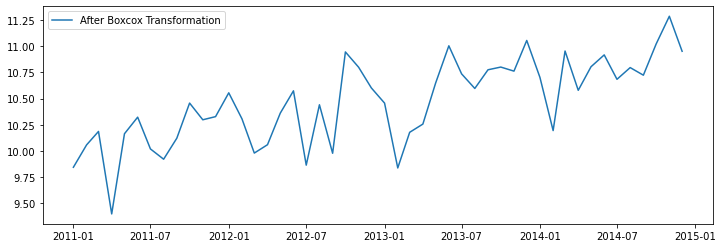

In [71]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data1['Sales'],lmbda = 0),index = data1.index)
plt.figure(figsize = (12,4))
plt.plot(data_boxcox,label = 'After Boxcox Transformation')
plt.legend(loc = 'best')
plt.show(block = False)

## Differencing, This is needed in AR , MA and ARMA test but it ARIMA test it is not required

In [72]:
data_boxcox_diff  = pd.Series(data_boxcox -  data_boxcox.shift(), index = data1.index)
data_boxcox_diff.drop(data_boxcox_diff.index[:1],inplace =True)
data_boxcox_diff.dropna(inplace = True)
## data_boxcox_diff has one entry less than data_boxcox

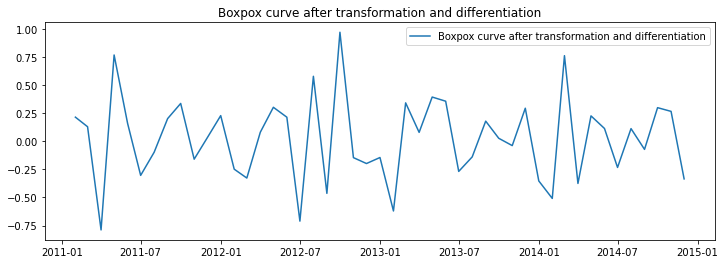

In [73]:
plt.figure(figsize =(12,4))
plt.plot(data_boxcox_diff,label = 'Boxpox curve after transformation and differentiation')
plt.title('Boxpox curve after transformation and differentiation')
plt.legend(loc = 'best')
plt.show(block = True)

### Now we will do the ADR and KPSS test 

In [74]:
from statsmodels.tsa.stattools import  adfuller
adf_test = adfuller(data_boxcox_diff)
print(f'The statistics for adf test is {adf_test[0]}')
print('Crtical Value @ 0.05 is:%f.2' % adf_test[4]['5%'])
print(f'The p value now is {adf_test[1]}')
#In hypothesis testing, a critical value is a point on the test distribution that is compared to the test statistic
#to determine whether to reject the null hypothesis. If the absolute value of your test statistic is greater than
#the critical value, you can declare statistical significance and reject the null hypothesis

The statistics for adf test is -4.5350113240543735
Crtical Value @ 0.05 is:-2.945951.2
The p value now is 0.00016989676321142527


#### so here we can reject the null hypothesis so the series is stationary

In [75]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_boxcox_diff)
print(f'The statistics of KPSS test is {kpss_test}')
print('Crtical Value of @ 0.05 is : %.2f'%kpss_test[3]['5%'])
print(f'The p value of kpss test is {kpss_test[1]}')
# so here the statistics is less than the critical value , so we fail to reject the null hypothesis 
# and in this test the null hypothesis says that the time series is stationary 

The statistics of KPSS test is (0.15645577441748107, 0.1, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Crtical Value of @ 0.05 is : 0.46
The p value of kpss test is 0.1


### AutoCorrelation Function Plots

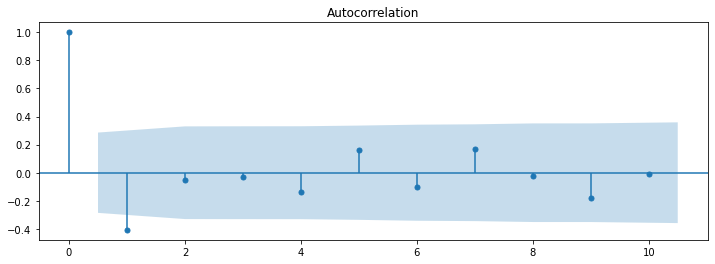

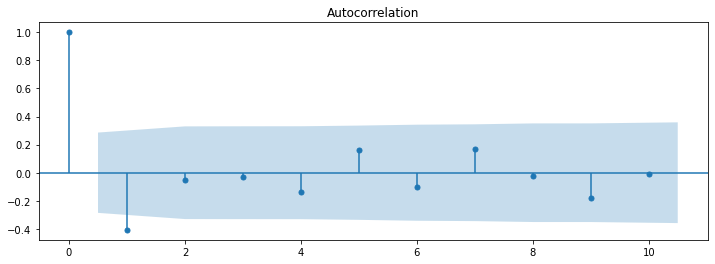

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize = (12,4))
plot_acf(data_boxcox_diff, ax = plt.gca(),lags = 10)

### Partial Auto Correlation Function 

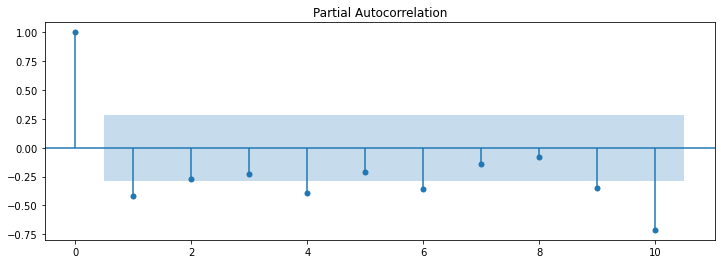

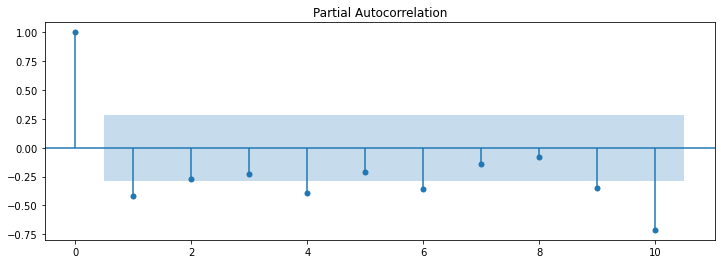

In [77]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize = (12,4))
plot_pacf(data_boxcox_diff,ax = plt.gca(),lags = 10)

### Split into training and test data sets

In [78]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### AR TEST

In [79]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff,order = (1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


here we know as it is a very simple model we have a constant and only one independent variable and  as the series is stationary the constant is close to zero. 

### Recover Original Time Series Fore cast

In [80]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
#data_boxcox_diff.index.min(),data_boxcox_diff.index.max()


- First we predit our model to the whole data from the minimum index to the maximum index (the complete series)
- Second we do the cumulative sum of the data points which is actually the reverse of the differentiating we did prior
- Third we add the first point which was deducted before doing the differentiation 
- Fourth we do the antilog or exp of data which was first transformed by taking the log of the values 

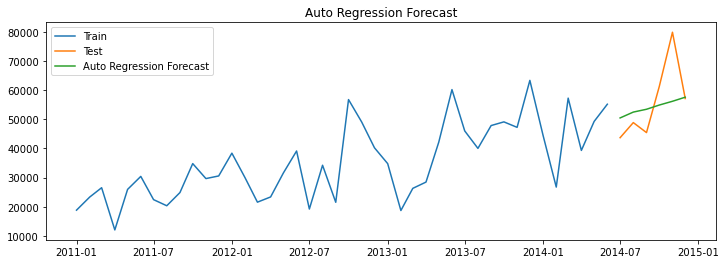

In [81]:
plt.figure(figsize= (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():],label = 'Auto Regression Forecast')
plt.legend(loc = 'best')
plt.title('Auto Regression Forecast')
plt.show()


In [82]:
rmse9 = round(np.sqrt(mean_squared_error(test["Sales"], y_hat_ar['ar_forecast'][train_len-1:])),2)
mape9 = round(np.mean(np.abs(test['Sales'] - y_hat_ar['ar_forecast'][train_len-1:])/test['Sales'])*100,2)

results8 = pd.DataFrame({'Method': ['AR model'],'RMSE':[rmse9],'MAPE':[mape9]})
results_7 = pd.concat([results1,results2,results3,results4,results5,results6,results7,results8])
results_7

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43
0,AR model,10985.28,13.56


### Moving average method

In [83]:
model = ARIMA(train_data_boxcox_diff,order =(0,0,1))
model_fit = model.fit() 
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


### Recover original time series forecast

In [84]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_boxcox_forecast_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ma['ma_boxcox_forecast'] = y_hat_ma['ma_boxcox_forecast_diff'].cumsum()
y_hat_ma['ma_boxcox_forecast'] = y_hat_ma['ma_boxcox_forecast'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_boxcox_forecast'])

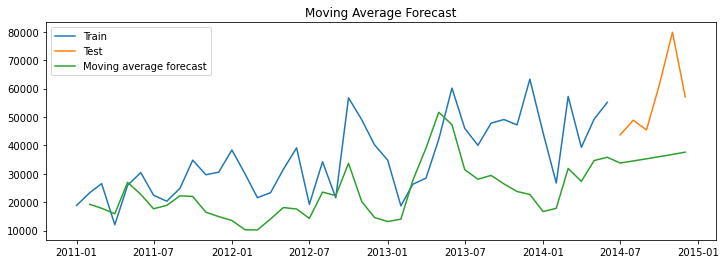

In [85]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_ma['ma_forecast'],label = 'Moving average forecast')
plt.title('Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()

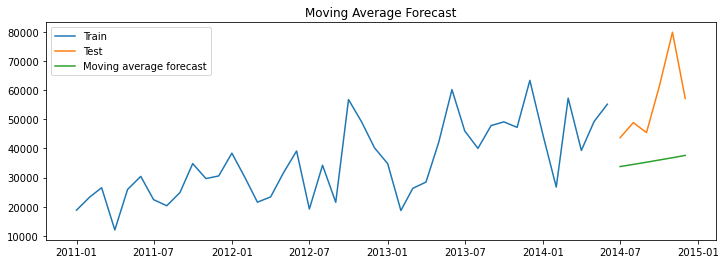

In [86]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():],label = 'Moving average forecast')
plt.title('Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()



In [87]:
rmse10 = round(np.sqrt(mean_squared_error(test["Sales"], y_hat_ma['ma_forecast'][train_len-1:])),2)
mape10 = round(np.mean(np.abs(test['Sales'] - y_hat_ma['ma_forecast'][train_len-1:])/test['Sales'])*100,2)
results9 = pd.DataFrame({'Method': ['MA model'],'RMSE':[rmse10],'MAPE':[mape10]})
results_8 = pd.concat([results1,results2,results3,results4,results5,results6,results7,results8,results9])
results_8

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43
0,AR model,10985.28,13.56
0,MA model,23360.02,33.93


### Auto Regressive Moving Average Method

In [88]:
model = ARIMA(train_data_boxcox_diff,order = (1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


In [89]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_boxcox_diff_forecast'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_boxcox_diff'] = y_hat_arma['arma_boxcox_diff_forecast'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_boxcox_diff'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

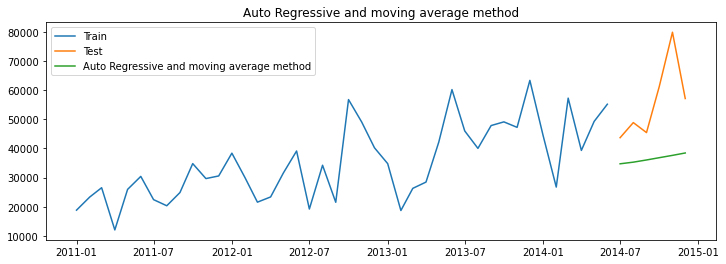

In [90]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():],label = 'Auto Regressive and moving average method')
plt.legend(loc = 'best')
plt.title('Auto Regressive and moving average method')
plt.show()

In [91]:
rmse11 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_arma['arma_forecast'][train_len-1:])),2)
mape11 = round(np.mean(np.abs(test['Sales'] - y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)
results10 = pd.DataFrame({'Method': ['ARMA model'],'RMSE':[rmse11],'MAPE':[mape11]})
results_9 = pd.concat([results1,results2,results3,results4,results5,results6,results7,results8,results9,results10])
results_9


,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43
0,AR model,10985.28,13.56
0,MA model,23360.02,33.93
0,ARMA model,22654.32,32.40


### ARIMA method

In [92]:
model = ARIMA(data_boxcox,order = (1,1,1))
model_fit = model.fit()
print(model_fit.params)

const        0.021517
ar.L1.D.y    0.076459
ma.L1.D.y   -1.000000
dtype: float64


### Recover the original Time Series

In [93]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_boxcox_diff_forecast'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_boxcox_diff'] = y_hat_arima['arima_boxcox_diff_forecast'].cumsum()
y_hat_arima['arima_boxcox_diff'] = y_hat_arima['arima_boxcox_diff'].add(data_boxcox[0])
y_hat_arima['arima_boxcox_forecast'] = np.exp(y_hat_arima['arima_boxcox_diff'])

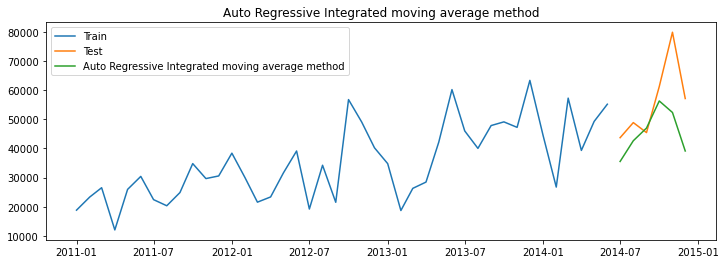

In [94]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_arima['arima_boxcox_forecast'][test.index.min():],label = 'Auto Regressive Integrated moving average method')
plt.legend(loc = 'best')
plt.title('Auto Regressive Integrated moving average method')
plt.show()

In [95]:
rmse12 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_arima['arima_boxcox_forecast'][train_len-1:])),2)
mape12 = round(np.mean(np.abs(test['Sales'] - y_hat_arima['arima_boxcox_forecast'][train_len-1:])/test['Sales'])*100,2)
results11 = pd.DataFrame({'Method': ['ARIMA'],'RMSE':[rmse12],'MAPE':[mape12]})
results_10 = pd.concat([results1,results2,results3,results4,results5,results6,results7,results8,results9,results10,results11])
results_10

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43
0,AR model,10985.28,13.56
0,MA model,23360.02,33.93
0,ARMA model,22654.32,32.40


### Seasonal Auto Regressive Integrated Moving Average  

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data_boxcox,order= (1,1,1),seasonal_order = (1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.066062
ma.L1      -0.998213
ar.S.L12   -0.010908
ma.S.L12   -0.982297
sigma2      0.047096
dtype: float64


In [97]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

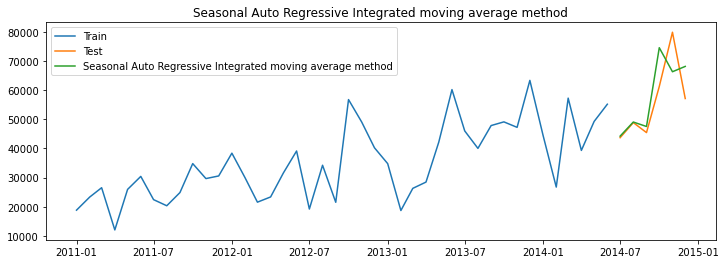

In [98]:
plt.figure(figsize = (12,4))
plt.plot(train['Sales'],label = 'Train')
plt.plot(test['Sales'],label = 'Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():],label = 'Seasonal Auto Regressive Integrated moving average method')
plt.legend(loc = 'best')
plt.title('Seasonal Auto Regressive Integrated moving average method')
plt.show()

In [99]:
rmse13 = round(np.sqrt(mean_squared_error(test['Sales'],y_hat_sarima['sarima_forecast'][train_len-1:])),2)
mape13 = round(np.mean(np.abs(test['Sales'] - y_hat_sarima['sarima_forecast'][train_len-1:])/test['Sales'])*100,2)
results12 = pd.DataFrame({'Method': ['SARIMA'],'RMSE':[rmse13],'MAPE':[mape13]})
results_11 = pd.concat([results1,results2,results3,results4,results5,results6,results7,results8,results9,results10,results11,results12])
results_11

,Method,RMSE,MAPE
0,Naive_Method,12355.97,17.47
0,Average_Method,24146.06,34.34
0,Simple Moving Average,15192.01,16.10
0,Simple Exponetial Smooothing,15011.49,15.99
0,Exponetial Smooothing,18976.37,34.57
0,Holts Exponential Smoothing Additive trend,9306.82,10.17
0,Holts Exponential Smoothing Multiplicative trend,9423.23,11.43
0,AR model,10985.28,13.56
0,MA model,23360.02,33.93
0,ARMA model,22654.32,32.40


### So we see that SARIMA model gives us the least value of MAPE , so we can prefer this model in the forecastiing 